Simulate Option Chain Gamma Projection With Throttle Coefficient From Flight Dynamics Model

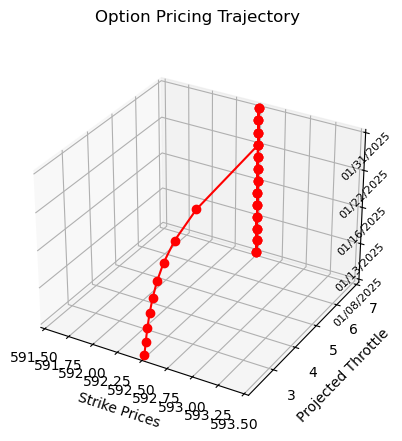

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Retrieve current market price using yfinance
def get_market_price(ticker):
    stock = yf.Ticker(ticker)
    return stock.history(period="1d")['Close'].iloc[-1]

# Calculate Gamma and Throttle
def calculate_gamma_and_throttle(strike, market_price, time_to_expiry, risk_free_rate, volatility):
    d1 = (np.log(market_price / strike) +
          (risk_free_rate + 0.5 * volatility**2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    gamma = norm.pdf(d1) / (market_price * volatility * np.sqrt(time_to_expiry))
    throttle = gamma * market_price
    return gamma, throttle

# Load and preprocess option chain data
def preprocess_option_data(csv_file, market_price, strike_range=0.2):
    # Load CSV and normalize column names
    df = pd.read_csv(csv_file, skiprows=3)
    df.columns = df.columns.str.strip().str.lower()

    # Validate required columns
    required_columns = {"strike", "ask", "expiration date"}
    if not required_columns.issubset(set(df.columns)):
        raise ValueError(f"CSV file must contain these columns: {required_columns}")

    # Filter strikes within a realistic range
    lower_bound = market_price * (1 - strike_range)
    upper_bound = market_price * (1 + strike_range)
    df = df[(df["strike"] >= lower_bound) & (df["strike"] <= upper_bound)]

    if df.empty:
        raise ValueError("Filtered DataFrame is empty. Ensure data matches the strike range.")
    
    return df

# Perform flight analysis
def flight_analysis(df, market_price, time_to_expiry, risk_free_rate, volatility):
    results = []
    for _, row in df.iterrows():
        gamma, throttle = calculate_gamma_and_throttle(row["strike"], market_price, time_to_expiry, risk_free_rate, volatility)
        results.append({
            "Strike": row["strike"],
            "Ask": row["ask"],
            "Gamma": gamma,
            "Throttle": throttle
        })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise ValueError("No valid rows after flight analysis. Check input data.")

    max_throttle_row = results_df.loc[results_df["Throttle"].idxmax()]
    return results_df, max_throttle_row

# Map expiration dates to ordinal integers for Z-axis
def map_expiration_dates(df):
    expiration_dates = pd.to_datetime(df["expiration date"], errors="coerce")
    if expiration_dates.isnull().any():
        raise ValueError("Invalid expiration dates. Ensure proper formatting in the 'Expiration Date' column.")

    # Format dates as MM/DD/YYYY for readability
    formatted_dates = expiration_dates.dt.strftime("%m/%d/%Y")
    
    # Create a mapping from formatted dates to ordinal values
    expiration_date_mapping = {date: i for i, date in enumerate(formatted_dates.unique())}
    df["expiration date ordinal"] = formatted_dates.map(expiration_date_mapping)
    return expiration_date_mapping

# Simulate and animate option trajectory
def simulate_and_animate_labeled(max_throttle_row, expiration_date_mapping, time_steps=50, save_as=None):
    initial_premium = max_throttle_row["Ask"]
    gamma = max_throttle_row["Gamma"]
    thrust = max_throttle_row["Throttle"]
    mass = 10

    x_positions, y_positions, z_positions = [], [], []
    for t in range(time_steps):
        effective_mass = max(1, mass - t)  # Avoid division by zero
        delta_change = thrust * gamma
        price = initial_premium + (thrust / effective_mass) + delta_change

        x_positions.append(max_throttle_row["Strike"])  # Strike Price
        y_positions.append(price)  # Projected Throttle
        z_positions.append(t % len(expiration_date_mapping))  # Expiration Date (ordinal)

    # Plot 3D animation
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("Option Pricing Trajectory", pad=20)  # Add padding for the title
    ax.set_xlabel("Strike Prices")
    ax.set_ylabel("Projected Throttle")
    ax.set_zlabel("Expiration Dates", labelpad=20)  # Add padding for Z-axis label

    # Update Z-axis ticks with formatted expiration date labels
    ordinal_values = list(expiration_date_mapping.values())
    date_labels = list(expiration_date_mapping.keys())

    # Adjust Z-axis ticks to reduce overlap
    z_tick_indices = np.linspace(0, len(ordinal_values) - 1, min(len(ordinal_values), 5)).astype(int)  # Show max 5 labels
    z_ticks = [ordinal_values[i] for i in z_tick_indices]
    z_labels = [date_labels[i] for i in z_tick_indices]

    ax.set_zticks(z_ticks)
    ax.set_zticklabels(z_labels, rotation=45, ha="right", fontsize=8)  # Rotate labels and adjust alignment

    def update(frame):
        ax.clear()
        ax.set_title("Option Pricing Trajectory", pad=20)  # Add padding for the title
        ax.set_xlabel("Strike Prices")
        ax.set_ylabel("Projected Throttle")
        ax.set_zlabel("Expiration Dates", labelpad=20)  # Add padding for Z-axis label
        ax.set_zticks(z_ticks)
        ax.set_zticklabels(z_labels, rotation=45, ha="right", fontsize=8)  # Rotate labels and adjust alignment

        # Calculate axis limits with margin
        x_min, x_max = min(x_positions[:frame + 1]), max(x_positions[:frame + 1])
        y_min, y_max = min(y_positions[:frame + 1]), max(y_positions[:frame + 1])
        z_min, z_max = min(z_positions[:frame + 1]), max(z_positions[:frame + 1])

        # Add margins if limits are identical
        margin = 1
        if x_min == x_max:
            x_min -= margin
            x_max += margin
        if y_min == y_max:
            y_min -= margin
            y_max += margin
        if z_min == z_max:
            z_min -= margin
            z_max += margin

        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

        # Plot trajectory
        ax.plot3D(x_positions[:frame], y_positions[:frame], z_positions[:frame], "r-o")

    ani = FuncAnimation(fig, update, frames=time_steps, repeat=False)
    if save_as:
        ani.save(save_as, writer="pillow")
    plt.show()

# Main script
if __name__ == "__main__":
    # Parameters
    ticker = "SPY"
    csv_file = r"F:\inputs\options\log\spy\01_09_2025\spy_quotedata.csv"
    time_to_expiry = 30 / 365  # Approx. 1 month
    risk_free_rate = 0.03
    volatility = 0.25
    strike_range = 0.2  # +-20% around market price

    # Retrieve market price
    market_price = get_market_price(ticker)

    # Preprocess data
    df = preprocess_option_data(csv_file, market_price, strike_range)

    # Perform flight analysis
    results_df, max_throttle_row = flight_analysis(df, market_price, time_to_expiry, risk_free_rate, volatility)

    # Map expiration dates
    expiration_date_mapping = map_expiration_dates(df)

    # Run animation
    simulate_and_animate_labeled(max_throttle_row, expiration_date_mapping, save_as="option_trajectory_labeled.gif")
